In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix

### 1. 学習データ生成用の関数定義

In [59]:
# ログ出力関数
def PrintLog(log):
    print(log)
    return

#### 訓練データ、テストデータをDataFrameに変換して返す

In [61]:
def ConvertDataFrame(p_x_data):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # 必要なカラムだけ抜き出す
    df_X = pd.DataFrame({"name":p_x_data[:, 1],
                            "category":p_x_data[:, 2],
                            "main_category":p_x_data[:, 3],
                            "currency":p_x_data[:, 4],
                            "deadline":p_x_data[:, 5],
                            "launched":p_x_data[:, 7],
                            "country":p_x_data[:, 11],
                            "usd_goal_real":p_x_data[:, 14]},
                            columns=["name", "category", "main_category", "currency", "deadline", 
                                    "launched", "country", "usd_goal_real"])
        
    __PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    return df_X

In [40]:
# 学習データ生成クラス
# 特徴量の追加、前処理を行う
class LearningDataCreator:
    
    # -----------------------
    # コンストラクタ
    # -----------------------
    def __init__(self, p_x_train, p_x_test):
        self.__PrintLog("enter : %s"%sys._getframe().f_code.co_name)
        
        # 訓練データ、テストデータをセット
        self.__x_train = p_x_train.copy()
        self.__x_test = p_x_test.copy()
        
        self.__PrintLog("leave : %s"%sys._getframe().f_code.co_name)
        
    # -----------------------
    # デストラクタ
    # -----------------------
    def __del__(self):
        self.__PrintLog("enter : %s"%sys._getframe().f_code.co_name)
        
        self.__PrintLog("leave : %s"%sys._getframe().f_code.co_name)

    # -----------------------
    # 学習用データの作成
    # メイン処理
    # -----------------------
    def GetLearningData(self):
        self.__PrintLog("enter : %s"%sys._getframe().f_code.co_name)
        
        # 扱いやすいようにDataFrameに変換
        df_x_train = self.__ConvertDataFrame(self.__x_train)
        df_x_test = self.__ConvertDataFrame(self.__x_test)
        
        # 特徴量の追加
        df_x_train = self.__CreateFeature(df_x_train)
        df_x_test = self.__CreateFeature(df_x_test)
        
        # 前処理
        df_x_train = self.__PreProcess(df_x_train)
        df_x_test = self.__PreProcess(df_x_test)
        
        # 不要なカラムを削除
        for col in ["name", "category", "main_category", "currency", "deadline", 
                    "launched", "country", "usd_goal_real", "country_success_rate_class", "main_category_success_rate_class"]:
            df_x_train = df_x_train.drop(col, axis = 1)
            df_x_test = df_x_test.drop(col, axis = 1)
            
        print("トレーニングデータ")
        display(df_x_train)
        print("テストデータ")
        display(df_x_test)
        
        self.__PrintLog("leave : %s"%sys._getframe().f_code.co_name)
        return df_x_train[:].values, df_x_test[:].values
        
    # -----------------------
    # 訓練データ、テストデータをDataFrameに変換して返す
    # -----------------------
    def __ConvertDataFrame(self, p_x_data):
        self.__PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
        # 必要なカラムだけ抜き出す
        df_X = pd.DataFrame({"name":p_x_data[:, 1],
                                "category":p_x_data[:, 2],
                                "main_category":p_x_data[:, 3],
                                "currency":p_x_data[:, 4],
                                "deadline":p_x_data[:, 5],
                                "launched":p_x_data[:, 7],
                                "country":p_x_data[:, 11],
                                "usd_goal_real":p_x_data[:, 14]},
                            columns=["name", "category", "main_category", "currency", "deadline", 
                                    "launched", "country", "usd_goal_real"])
        
        self.__PrintLog("leave : %s"%sys._getframe().f_code.co_name)
        return df_X
    
    # -----------------------
    # 特徴量を追加したDataFrameを返す
    # -----------------------
    def __CreateFeature(self, p_df_x_data):
        self.__PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
        # 成功率が高い国か、そうでないかのカラムを追加(33%をしきい値とする)
        country_index = (p_df_x_data["country"] == "US") | \
                            (p_df_x_data["country"] == "GB") | \
                            (p_df_x_data["country"] == "CA") | \
                            (p_df_x_data["country"] == "FR") | \
                            (p_df_x_data["country"] == "SE") | \
                            (p_df_x_data["country"] == "NZ") | \
                            (p_df_x_data["country"] == "DK") | \
                            (p_df_x_data["country"] == "HK") | \
                            (p_df_x_data["country"] == "SG") | \
                            (p_df_x_data["country"] == "LU")
        p_df_x_data.loc[country_index, "country_success_rate_class"] = "high"
        p_df_x_data.loc[~country_index, "country_success_rate_class"] = "low"
        
        # カテゴリ別で成功率が低位の層、中間の層、上位の層を分けるカラムを追加する
        # 低位層：成功率40%未満、中間層：40%以上 60%未満、上位層：60%以上
        cate_high_index = (p_df_x_data["main_category"] == "Dance") | \
                            (p_df_x_data["main_category"] == "Theater") | \
                            (p_df_x_data["main_category"] == "Comics")
        cate_low_index = (p_df_x_data["main_category"] == "Publishing") | \
                            (p_df_x_data["main_category"] == "Photography") | \
                            (p_df_x_data["main_category"] == "Fasion") | \
                            (p_df_x_data["main_category"] == "Food") | \
                            (p_df_x_data["main_category"] == "Crafts") | \
                            (p_df_x_data["main_category"] == "journalism") | \
                            (p_df_x_data["main_category"] == "Technology")
        p_df_x_data.loc[cate_high_index, "main_category_success_rate_class"] = "high"
        p_df_x_data.loc[~(cate_high_index | cate_low_index), "main_category_success_rate_class"] = "mid"
        p_df_x_data.loc[cate_low_index, "main_category_success_rate_class"] = "low"

        self.__PrintLog("leave : %s"%sys._getframe().f_code.co_name)
        return p_df_x_data
    
    # -----------------------
    # 前処理
    # -----------------------
    def __PreProcess(self, p_df_x_data):
        self.__PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
        # One-hotベクトル
        p_df_x_data = pd.concat([p_df_x_data, 
                                 pd.get_dummies(p_df_x_data["country_success_rate_class"], prefix="country"),
                                 pd.get_dummies(p_df_x_data["main_category_success_rate_class"], prefix="main_category")],
                                    axis = 1)
        
        display(p_df_x_data.head())
        self.__PrintLog("leave : %s"%sys._getframe().f_code.co_name)
        return p_df_x_data
    
    # -----------------------
    # ログ出力
    # -----------------------
    def __PrintLog(self, log):
        print(log)
        return

### 2. データの読み込み

In [18]:
df_origin = pd.read_csv("../ks-projects-201801.csv")

# データ表示
display(df_origin.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [55]:
df = df_origin.copy()


In [42]:
# 訓練データとテストデータを分ける
df = df[df["state"] != "live"]
df["state"] = df["state"]=="successful"
X = df[:].values
y = df["state"].values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [56]:
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


### 3. 学習データ作成

In [43]:
# 学習データ生成クラスでデータ作成
creator = LearningDataCreator(X_train, X_test)
X_train, X_test = creator.GetLearningData()
del creator

enter : __init__
leave : __init__
enter : GetLearningData
enter : __ConvertDataFrame
leave : __ConvertDataFrame
enter : __ConvertDataFrame
leave : __ConvertDataFrame
enter : __CreateFeature
leave : __CreateFeature
enter : __CreateFeature
leave : __CreateFeature
enter : __PreProcess


,name,category,main_category,currency,deadline,launched,country,usd_goal_real,country_success_rate_class,main_category_success_rate_class,country_high,country_low,main_category_high,main_category_low,main_category_mid
0,"""Faith Lost"" a short film",Film & Video,Film & Video,USD,2014-07-03,2014-06-03 21:55:09,US,5000,high,mid,1,0,0,0,1
1,The Appearing,Narrative Film,Film & Video,USD,2011-12-10,2011-10-11 01:21:25,US,20000,high,mid,1,0,0,0,1
2,"Help us take Swirl + Sparkle to QVC, HSN and b...",Product Design,Design,USD,2016-09-29,2016-08-30 17:53:27,US,15000,high,mid,1,0,0,0,1
3,TEX-SHIELD The legend of a Texas Superhero,Comics,Comics,USD,2011-08-30,2011-07-01 02:26:12,US,15000,high,high,1,0,1,0,0
4,Meow Meow ( A Cat Cafe ),Events,Food,USD,2015-10-01,2015-08-30 22:49:34,US,20000,high,low,1,0,0,1,0


leave : __PreProcess
enter : __PreProcess


,name,category,main_category,currency,deadline,launched,country,usd_goal_real,country_success_rate_class,main_category_success_rate_class,country_high,country_low,main_category_high,main_category_low,main_category_mid
0,"""Domino Effect"" (Canceled)",Pop,Music,USD,2015-08-11,2015-06-12 16:10:31,US,30000,high,mid,1,0,0,0,1
1,"JBIRD COLLECTIVE, Reinventing men's carry goods",Product Design,Design,USD,2013-11-01,2013-10-01 15:10:59,US,12000,high,mid,1,0,0,0,1
2,The Running On Empty Pilot,Film & Video,Film & Video,USD,2012-11-30,2012-10-31 02:15:31,US,5000,high,mid,1,0,0,0,1
3,Stephen DiRado Up-Island: A book of photographs,Photobooks,Photography,USD,2017-12-10,2017-10-20 14:58:27,US,29500,high,low,1,0,0,1,0
4,Ascendancy: The Game of Warring Factions,Tabletop Games,Games,USD,2014-08-14,2014-07-15 05:11:31,US,8000,high,mid,1,0,0,0,1


leave : __PreProcess
トレーニングデータ


,country_high,country_low,main_category_high,main_category_low,main_category_mid
0,1,0,0,0,1
1,1,0,0,0,1
2,1,0,0,0,1
3,1,0,1,0,0
4,1,0,0,1,0
5,1,0,0,0,1
6,1,0,0,1,0
7,1,0,0,0,1
8,1,0,0,0,1
9,1,0,1,0,0


テストデータ


,country_high,country_low,main_category_high,main_category_low,main_category_mid
0,1,0,0,0,1
1,1,0,0,0,1
2,1,0,0,0,1
3,1,0,0,1,0
4,1,0,0,0,1
5,1,0,0,1,0
6,1,0,0,0,1
7,1,0,0,0,1
8,1,0,0,0,1
9,1,0,1,0,0


leave : GetLearningData
enter : __del__
leave : __del__


### 4. 学習

score= 0.654463581973401
[0.07766135 0.14615891 0.23547874 0.32700987 0.21369113]


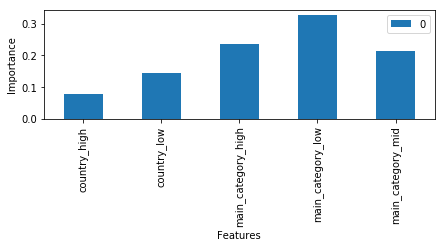

Wall time: 1.16 s


In [50]:
%%time

# ランダムフォレスト
clf = RandomForestClassifier(n_estimators=10, max_depth=50, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=["country_high", "country_low", "main_category_high", "main_category_low", "main_category_mid"]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### 5. 評価

In [51]:
# ラベルを予測
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# 表示
print("対数尤度 = {:.3f}".format(- log_loss(y_test, y_pred)))
print("Accuracy(正答率) = {:.3f}%".format(accuracy * 100))
print("Precision(適合率) = {:.3f}%".format(precision[1] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[1] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[1] * 100))

対数尤度 = -11.861
Accuracy(正答率) = 65.658%
Precision(適合率) = 58.944%
Recall(再現率) = 10.874%
F1-score(F1値) = 18.361%


In [52]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=["正解 = failed", "正解 = successful"], 
                        columns=["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,46454,2022
正解 = successful,23794,2903
